# __Introduction__

Fake news, misinformation, and disinformation plague our online websites and mislead millions of people who get their news online. Using Data Science, we aim to evaluate the level of risk to which a web page may contain false information, based on text variables such as the number of grammatical errors. Then we will assign the web page a numerical “risk” factor from 0, where 0 is almost certainly false and 1 is almost certainly true. This will help the reader judge what they are reading and determine whether or not the page contains misleading information.


# Imports

Here are all the general imports needed. 

In [4]:
import sys
!{sys.executable} -m pip install __upgrade pip
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install scikit-plot==0.3.7

# Import libraries

import numpy as np
import spacy as sp
import pandas as pd

import string
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Invalid requirement: '__upgrade'



Shows an example text being broken down using nlp. The most important catagory to make note of is the boolean __Stopwords__ row. Later in the program all stopwrds will be removed for better analysis of the text.

In [5]:
# Load English tokenizer, tagger, parser and NER
nlp = sp.load("en_core_web_sm")

# Process whole documents
text = ("When Sebastian Thrun started working on self-driving cars at "
        "Google in 2007, few people outside of the company took him "
        "seriously. “I can tell you very senior CEOs of major American "
        "car companies would shake my hand and turn away because I wasn’t "
        "worth talking to,” said Thrun, in an interview with Recode earlier "
        "this week.")
doc = nlp(text)

cols = ("text", "lemma", "POS", "explain", "stopword")
rows = []
for t in doc:
    row = [t.text, t.lemma_, t.pos_, sp.explain(t.pos_), t.is_stop]
    rows.append(row)
df = pd.DataFrame(rows, columns=cols)
print(df)

         text      lemma    POS                    explain  stopword
0        When       when  SCONJ  subordinating conjunction      True
1   Sebastian  Sebastian  PROPN                proper noun     False
2       Thrun      Thrun  PROPN                proper noun     False
3     started      start   VERB                       verb     False
4     working       work   VERB                       verb     False
5          on         on    ADP                 adposition      True
6        self       self   NOUN                       noun     False
7           -          -  PUNCT                punctuation     False
8     driving      drive   VERB                       verb     False
9        cars        car   NOUN                       noun     False
10         at         at    ADP                 adposition      True
11     Google     Google  PROPN                proper noun     False
12         in         in    ADP                 adposition      True
13       2007       2007    NUM   

# __Importing__

Grabbing the data from the database excel files and formatting into pandas df. Keeping the columns of text and label.

In [10]:
dfFalse = pd.read_csv (r'Databases/Data1/Fake.csv')
ds1 = pd.DataFrame()
ds1["text"] = dfFalse["text"]
ds1.insert(0, 'label', 'fake')
dfTrue = pd.read_csv (r'Databases/Data1/True.csv')
ds2 = pd.DataFrame()
ds2["text"] = dfTrue["text"]
ds2.insert(0, 'label', 'true')
dataset1 = pd.concat([ds1, ds2])
dataset1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

print(dataset1.head(5))

  label                                               text
0  fake  Donald Trump just couldn t wish all Americans ...
1  fake  House Intelligence Committee Chairman Devin Nu...
2  fake  On Friday, it was revealed that former Milwauk...
3  fake  On Christmas day, Donald Trump announced that ...
4  fake  Pope Francis used his annual Christmas Day mes...


# __Preprosessing text__

Define the process to only keep alpha characters and remove any stopwords. Changes all characters to lowercase. The number of true and false data pints are printed out to make sure the dataset isn't skewed.

In [11]:
nltk.download('stopwords')

def text_preprocess(message):
    # Remove punctuations
    nopunc = [char for char in message if char not in string.punctuation]

    # Join the characters again
    nopunc = "".join(nopunc)
    nopunc = nopunc.lower()

    # Remove any stopwords and characters that arent letters
    nostop = [
        word
        for word in nopunc.split()
        if word.lower() not in stopwords.words("english") and word.isalpha()
    ]
    return nostop


false_text = dataset1[dataset1["label"] == "fake"]["text"]
true_text = dataset1[dataset1["label"] == "true"]["text"]
print(f"Number of fake messages: {len(false_text)}")
print(f"Number of true messages: {len(true_text)}")



Number of fake messages: 23450
Number of true messages: 21417


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jjfri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# __Apply the text preprocess__
This section of code runs of the longer side (90 min). Drops any rows with n/a values then shuffles the dataset and resets the index numbers. Then applys the preprocess to the text column of the dataset.

In [12]:
####################################################################### TAKES FOREVER TO PROSESS
from sklearn.utils import shuffle
dataset1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
data_shuffled = dataset1.sample(frac=1).reset_index(drop=True)
print(data_shuffled.head(20))

# 0.0878 seconds per row // 89.922 min for entire dataset

# Remove punctuations/stopwords from all messages
data_shuffled["text"] = data_shuffled["text"].apply(text_preprocess)
data_shuffled.head(20)



   label                                               text
0   fake  Two high profile black people giving commencem...
1   true   President Donald Trump’s call for Congress to...
2   fake  Donald Trump s best efforts to smear Democrati...
3   true   As U.S. President Donald Trump left  on Frida...
4   fake  The despicable anti-free speech, communist clo...
5   true  BUDAPESTWARSAW Wary of German Chancellor Angel...
6   true  Detroit Mayor Mike Duggan proposed a $2.6 bill...
7   true   North Korea s nuclear threat looms large this...
8   true   Democratic U.S. Senator Elizabeth Warren will...
9   fake  Remember when this would seem like a far-fetch...
10  fake  The Atlantic, a publication that wouldn t know...
11  true   U.S. House of Representatives lawmakers will ...
12  true  COPENHAGEN Denmark intends to invest to boost ...
13  true  NAIROBI A United States citizen working in Sou...
14  true   U.S. President Donald Trump’s Cabinet is wort...
15  fake  Seriously? How pathetic is thi

,label,text
0,fake,"[two, high, profile, black, people, giving, co..."
1,true,"[president, donald, call, congress, toughen, i..."
2,fake,"[donald, trump, best, efforts, smear, democrat..."
3,true,"[us, president, donald, trump, left, friday, a..."
4,fake,"[despicable, antifree, speech, communist, clow..."
5,true,"[budapestwarsaw, wary, german, chancellor, ang..."
6,true,"[detroit, mayor, mike, duggan, proposed, billi..."
7,true,"[north, korea, nuclear, threat, looms, large, ..."
8,true,"[democratic, us, senator, elizabeth, warren, k..."
9,fake,"[remember, would, seem, like, farfetched, idea..."


In [1]:
# lengths = data_shuffled["text"].str.len()
# argmax = np.where(lengths == lengths.min())[0]
# df.iloc[argmax]

NameError: name 'data_shuffled' is not defined

# __Extracting Variables__
Reformats the data
vectorizes extracts and transforms data 

In [2]:
# Convert messages (as lists of string tokens) to strings
data_shuffled["text"] = data_shuffled["text"].agg(lambda x: " ".join(map(str, x)))
data_shuffled.head()

# Initialize count vectorizer
vectorizer = CountVectorizer()
bow_transformer = vectorizer.fit(data_shuffled["text"])

# Fetch the vocabulary set
print(f"20 BOW Features: {vectorizer.get_feature_names()[20:40]}")
print(f"Total number of vocab words: {len(vectorizer.vocabulary_)}")

# Convert strings to vectors using BoW
dataset1_bow = bow_transformer.transform(data_shuffled["text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {dataset1_bow.shape}")
print(f"Amount of non-zero occurrences: {dataset1_bow.nnz}")

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(dataset1_bow)

# Transform entire BoW into tf-idf corpus
messages_tfidf = tfidf_transformer.transform(dataset1_bow)
print(messages_tfidf.shape)

# Convert spam and ham labels to 0 and 1 (or, vice-versa)
FactorResult = pd.factorize(data_shuffled["label"])
data_shuffled["label"] = FactorResult[0]
data_shuffled.head()


NameError: name 'data_shuffled' is not defined

In [1]:
# __Spliting and Training__


In [32]:
# Split the dataset to train and test sets
msg_train, msg_test, label_train, label_test = train_test_split(
    messages_tfidf, data_shuffled["label"], test_size=0.2
)

print(f"train dataset features size: {msg_train.shape}")
print(f"train dataset label size: {label_train.shape}")

print(f"test dataset features size: {msg_test.shape}")
print(f"test dataset label size: {label_test.shape}")

# Train an xgboost classifier
from xgboost import XGBClassifier

# Instantiate our model
clf = XGBClassifier()

# Fit the model to the training data
clf.fit(msg_train, label_train)


# Make predictions
predict_train = clf.predict(msg_train)

print(
    f"Accuracy of Train dataset: {metrics.accuracy_score(label_train, predict_train):0.3f}"
)

# an example prediction
print(
    "predicted:",
    clf.predict(
        tfidf_transformer.transform(bow_transformer.transform([data_shuffled["text"][9]]))
    )[0],
)
print("expected:", data_shuffled["label"][9])

# print the overall accuracy of the model
label_predictions = clf.predict(msg_test)
print(f"Accuracy of the model: {metrics.accuracy_score(label_test, label_predictions):0.3f}")

train dataset features size: (35893, 204269)
train dataset label size: (35893,)
test dataset features size: (8974, 204269)
test dataset label size: (8974,)
Accuracy of Train dataset: 0.999
predicted: 0
expected: 0
Accuracy of the model: 0.988


Accuracy of the model: 0.988


c:\Users\jjfri\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


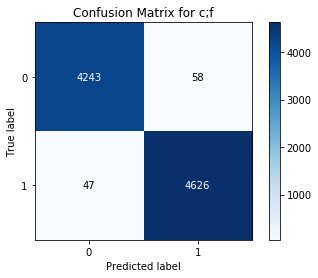

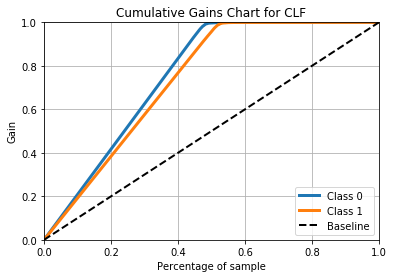

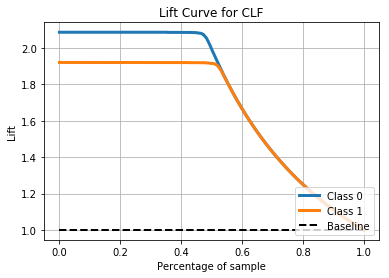

In [65]:
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
import scikitplot as skplt

label_predictions = clf.predict(msg_test)
print(f"Accuracy of the model: {metrics.accuracy_score(label_test, label_predictions):0.3f}")

y_rfc_proba = clf.predict_proba(msg_test)
y_rfc_pred = np.where(y_rfc_proba[:,1] > 0.5, 1, 0)

skplt.metrics.plot_confusion_matrix(label_test, y_rfc_pred, normalize=False, title = 'Confusion Matrix for c;f')

skplt.metrics.plot_cumulative_gain(label_test, y_rfc_proba, title = 'Cumulative Gains Chart for CLF')

skplt.metrics.plot_lift_curve(label_test, y_rfc_proba, title = 'Lift Curve for CLF')

In [14]:
# reformatting data into a smaller group to make grid search manigeable

print(data_shuffled.shape)
print(messages_tfidf.shape)

data_shuffled_1 = data_shuffled.iloc[:25000,:]

print(data_shuffled_1.shape)

# Initialize count vectorizer
vectorizer_1 = CountVectorizer()
bow_transformer_1 = vectorizer_1.fit(data_shuffled_1["text"])

# Fetch the vocabulary set
print(f"20 BOW Features: {vectorizer_1.get_feature_names()[20:40]}")
print(f"Total number of vocab words: {len(vectorizer_1.vocabulary_)}")

# Convert strings to vectors using BoW
dataset1_bow_1 = bow_transformer_1.transform(data_shuffled_1["text"])

# Print the shape of the sparse matrix and count the number of non-zero occurrences
print(f"Shape of sparse matrix: {dataset1_bow_1.shape}")
print(f"Amount of non-zero occurrences: {dataset1_bow_1.nnz}")


# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer_1 = TfidfTransformer().fit(dataset1_bow_1)

# Transform entire BoW into tf-idf corpus
messages_tfidf_1 = tfidf_transformer_1.transform(dataset1_bow_1)
print(messages_tfidf_1.shape)

# Convert spam and ham labels to 0 and 1 (or, vice-versa)
FactorResult_1 = pd.factorize(data_shuffled_1["label"])
data_shuffled_1["label"] = FactorResult_1[0]


(44869, 2)
(44869, 204269)
(25000, 2)
20 BOW Features: ['aaminus', 'aammir', 'aamom', 'aampampacbreturn', 'aampampbcbparsefloatastringbaeffunctionavar', 'aampexkamp', 'aan', 'aapi', 'aapl', 'aaplo', 'aaplus', 'aapplybcreturn', 'aapplythisbmdatenowfunctionreturnnew', 'aar', 'aardal', 'aardvark', 'aardvarks', 'aargh', 'aaron', 'aarondfordnv']
Total number of vocab words: 150717
Shape of sparse matrix: (25000, 150717)
Amount of non-zero occurrences: 3923831
(25000, 150717)


c:\Users\jjfri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
# Split the dataset to train and test sets
msg_train_1, msg_test_1, label_train_1, label_test_1 = train_test_split(
    messages_tfidf_1, data_shuffled_1["label"], test_size=0.3
)

In [16]:
# 482min
from sklearn.model_selection import GridSearchCV
clf_2 = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.15, 0.20, 0.25, 0.30 ] , #0.2 optimal
     "max_depth"        : [5, 6, 8, 10, 15, 18, 20], # 15 optimal
     "min_child_weight" : [ 1, 3], # 1 optimal
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6], #0.4 optimal
     "colsample_bytree" : [0.1, 0.2, 0.3, 0.4, 0.5] # 0.3 optimal
     }
grid = GridSearchCV(clf_2,
                    parameters, n_jobs=8,
                    scoring="neg_log_loss",
                    cv=3)
grid.fit(msg_train_1, label_train_1)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
       colsample_bylevel=None, colsample_bynode=None,
       colsample_bytree=None, early_stopping_rounds=None,
       enable_categorical=False, eval_metric=None, gamma=None, gpu_id=None,
       grow_policy=None, importance_type=...,
       tree_method=None, use_label_encoder=False, validate_parameters=None,
       verbosity=None),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'eta': [0.15, 0.2, 0.25, 0.3], 'max_depth': [5, 6, 8, 10, 15], 'min_child_weight': [1, 3], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix 

# print best parameter after tuning 
print(grid.best_params_) # best parameters {'colsample_bytree': 0.3, 'eta': 0.2, 'gamma': 0.4, 'max_depth': 15, 'min_child_weight': 1}
print(grid.cv_results_) # all params
grid_predictions = grid.predict(msg_test_1) 
   
# print classification report 
print(classification_report(label_test_1, grid_predictions)) 

{'colsample_bytree': 0.3, 'eta': 0.2, 'gamma': 0.4, 'max_depth': 15, 'min_child_weight': 1}
{'mean_fit_time': array([ 13.58861995,  11.56672549,  15.04779053,  13.06099629,
        19.21237381,  16.08360124,  22.48020792,  19.01574326,
        29.40740093,  24.22300331,  13.6000243 ,  12.16083034,
        15.3483727 ,  14.37718558,  19.93456205,  17.08602961,
        23.97610958,  21.53135475,  32.94224366,  26.50362722,
        14.35897287,  12.60817409,  16.55818415,  14.22325746,
        20.01609429,  17.3695341 ,  23.59986663,  19.69065817,
        30.70818496,  25.30962785,  13.95633245,  12.11259619,
        15.91874798,  13.80440458,  20.30183109,  16.87433434,
        22.97762545,  20.19829965,  30.53864463,  25.63343358,
        14.05895114,  12.37755497,  16.45797229,  13.99722226,
        20.00481757,  17.17117294,  23.55664158,  19.81930621,
        31.0339946 ,  25.40545805,  13.17658655,  12.11026994,
        15.67706148,  13.57601611,  19.39578176,  16.52512566,
        

In [24]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

print(xgb.__version__)



# We need to prepare data as DMatrix objects
train = xgb.DMatrix(msg_train, label_train)
test = xgb.DMatrix(msg_test, label_test)


# We need to define parameters as dict
params = grid.best_params_

# training, we set the early stopping rounds parameter
model_xgb = xgb.train(params, 
          train, evals=[(train, "train"), (test, "validation")])


import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model_xgb.predict(test, ntree_limit=model_xgb.best_ntree_limit)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))

1.6.1
[0]	train-rmse:0.42252	validation-rmse:0.43164
[1]	train-rmse:0.37275	validation-rmse:0.38852
[2]	train-rmse:0.32796	validation-rmse:0.34945
[3]	train-rmse:0.28779	validation-rmse:0.31392
[4]	train-rmse:0.25006	validation-rmse:0.28123
[5]	train-rmse:0.22086	validation-rmse:0.25720
[6]	train-rmse:0.20517	validation-rmse:0.24363
[7]	train-rmse:0.19016	validation-rmse:0.23159
[8]	train-rmse:0.17624	validation-rmse:0.22072
[9]	train-rmse:0.16279	validation-rmse:0.21033
Precision = 0.2639291285937152
Recall = 0.5
Accuracy = 0.5278582571874304


c:\Users\jjfri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of the model: 0.985


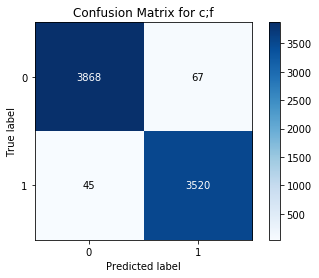

In [25]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
import scikitplot as skplt

label_predictions_1 = grid.predict(msg_test_1)
print(f"Accuracy of the model: {metrics.accuracy_score(label_test_1, label_predictions_1):0.3f}")

y_rfc_proba_1 = grid.predict_proba(msg_test_1)
y_rfc_pred_1 = np.where(y_rfc_proba_1[:,1] > 0.5, 1, 0)

skplt.metrics.plot_confusion_matrix(label_test_1, y_rfc_pred_1, normalize=False, title = 'Confusion Matrix for c;f')

# skplt.metrics.plot_roc(label_test_1, y_rfc_proba_1, title = 'ROC Plot for clf')

# skplt.metrics.plot_precision_recall(label_test_1, y_rfc_proba_1, title = 'PR Curve for clf')

# skplt.metrics.plot_cumulative_gain(label_test_1, y_rfc_proba_1, title = 'Cumulative Gains Chart for CLF')

# skplt.metrics.plot_lift_curve(label_test_1, y_rfc_proba_1, title = 'Lift Curve for CLF')

In [1]:
False1 = """Man says he delivered manure to Mnuchin to protest new U.S. tax law," (In Dec. 25 story, in second paragraph, corrects name of Strong’s employer to Mental Health Department, not Public Health Department.) By Bernie Woodall (Reuters) - A man claiming to be the person who delivered a gift-wrapped package of horse manure at the Los Angeles home of U.S. Treasury Secretary Steven Mnuchin said on Monday he did it to protest the federal tax overhaul signed into law last week by President Donald Trump. Robert Strong, 45, a psychologist for the Los Angeles County Mental Health Department, said by telephone he left the poop-filled parcel addressed to Mnuchin and Trump in the driveway outside Mnuchin’s home in the posh Bel Air community.  KNBC-TV, an NBC television affiliate in Los Angeles, reported Mnuchin was not home at the time. The package was found by Mnuchin’s neighbor.    “Protest really should be funny,” Strong told Reuters. “People’s eyes glaze over when they just see angry people in the streets.” He believes the new tax law will hurt poor people. Neither the U.S. Secret Service nor the Los Angeles Police Department, both of which investigated the incident, would confirm Strong was responsible. The Secret Service interviewed an individual who admitted delivering the package, but no charges had been filed against him as of Monday afternoon. LAPD Lieutenant Rob Weise said it was possible whoever left the package did not break any criminal laws. While he is not assigned to investigate the incident, Weise said if the box did not present any danger, it would not be illegal. The LAPD bomb squad X-rayed the box before opening it on Saturday. In a photo of the card Strong posted on Twitter, he wrote “Misters Mnuchin & Trump, We’re returning the ‘gift’ of the Christmas tax bill” and signed it “Warmest wishes, The American people.”      Strong said a Secret Service agent, accompanied by six police officers, showed up at his house to question him on Sunday night, and the agent chided him, asking, “‘Are you ashamed of your behavior?’”     The White House declined to comment on Monday and officials with the Treasury Department could not be reached."""

False2 = '''NEW DELHI (Reuters) - Indian Prime Minister Narendra Modi plans to reshuffle his cabinet over the next two days and some mid-level ministers have offered to quit to pave the way for changes, sources in the party and aides to the ministers said. A revamp of the cabinet has been on the cards for months because some ministers are holding multiple portfolios which is seen as a drag on efficiency. Modi is also seeking to improve governance before he seeks re-election in 2019.     With economic growth slowing to its slowest pace in three years, Modi is coming under pressure to deliver the promises he made in 2014.     There was no official announcement of the cabinet revamp but  sources Reuters spoke to said if it took place it would have to be done before Modi leaves on a foreign tour on Sunday.     The death of Environment Minister Anil Madhav Dave and the election of Minister for Urban Development M. Venkaiah Naidu as vice-president opened vacancies, giving Modi an opportunity to bring in members from regional political parties.     According to four party sources, Sanjeev Balyan, minister of state for water resources, Rajiv Pratap Rudy, minister of state for skill development and entrepreneurship, Kalraj Mishra, minister of micro, small and medium enterprises, and Mahendra Nath Pandey minister of state for human resource development have all offered to resign.'''


True1 = '''Brooklyn College is advising New York City police officers to use bathrooms on the far end of campus in order to avoid being seen by students who might be offended by their presence.The Excelsior, the college is student newspaper, reported last week that Director of Public Safety Donald Wenz would  prefer  if members of the New York Police Department (NYPD) used facilities in the West End Building (WEB)  rather than walking across either quad to use the bathroom. Wenz is comments come in the wake of a film screening of the movie  Watched,  which documents an NYPD informant who surveilled Muslim students on campus for a period of four years as part of the city is counterterrorism efforts. After the screening, students were allowed to share their thoughts on having NYPD officers on campus. I disagree with them being on campus. Especially allowing them to use the building where student groups are held,  one unidentified student remarked, according to The Excelsior, later noting that he would be sending a petition to College President Michelle Anderson, pressuring her to issue a statement  that we do not want the NYPD on campus in any respect even if it is just to take breaks and use bathrooms. After discovering The Excelsior is report, The New York Post took a trip to the WEB, where officers are now encouraged to use the bathroom, and found an  out of order  sign on the stall door, with a dirty and broken toilet on the inside. The bathroom is horrendous. You can only wash your hands in one of the sinks because the other two are broken,  one student told the Post, though others argued that NYPD should not be allowed on campus at all. I know students from every background and across every major. They don t feel comfortable around cops. They just don t. It makes safe spaces feel not so safe,  one unidentified student remarked, with another telling the Post that it is  weird  seeing cops on campus.But members of the NYPD who monitor the neighborhood surrounding the school told the Post that the student sentiments are  insane.    Campus Reform '''

True2 = '''UVALDE, Texas (AP) — Facing massive public pressure, Uvalde’s top school official has recommended the firing of the school district police chief who was central to the botched law enforcement response to the elementary school shooting nearly two months ago that killed two teachers and 19 students.

The South Texas city’s school board announced Wednesday that it will consider firing Chief Pete Arredondo at a special meeting Saturday. Arredondo has been accused by state officials of making several critical mistakes during the May 24 mass shooting at Robb Elementary School.

School officials have previously resisted calls to fire Arredondo. The announcement comes two days after a meeting where the school board members were lambasted for more than three hours by members of the public, who accused them of not implementing basic security at Robb, of not being transparent about what happened and of failing to hold Arredondo to account for his actions.

Confronted with parents’ vociferous demands to fire Arredondo and warnings that his job would be next, Superintendent Hal Harrell said Monday that the police chief was a contract employee who could not be fired at will. The agenda for Saturday’s meeting includes the board discussing the potential firing with its lawyer. Arredondo, who has been on leave from the district since June 22, has faced blistering criticism since the massacre, most notably for not ordering officers to immediately breach the classroom where an 18-year-old gunman carried out the attack. If fired, Arredondo would become the first officer ousted from his job following the deadliest Texas school shooting in history.

Although nearly 400 officers from various agencies were involved in the police response that took more than an hour to confront and kill the shooter, Arredondo is one of only two known to have faced discipline. His attorney did not immediately respond to requests for comment.

The move to potentially fire the chief follows the release of a damning 80-page report by a Texas House committee that blamed all levels of law enforcement for a slow and chaotic response. The report found that 376 law enforcement officers massed at the school, with more than half coming from state and federal agencies, but that they “failed to adhere to their active shooter training, and they failed to prioritize saving innocent lives over their own safety.” According to the committee, Arredondo told lawmakers he didn’t consider himself the on-scene commander in charge and that his priority was to protect children in other classrooms. The committee report called that decision a “terrible, tragic mistake.”

Body camera footage released by the Uvalde officials shows Arredondo in the hallway trying multiple sets of keys on other classroom doors, but not the one where the massacre took place. The classroom door could not be locked from the inside, but there is no indication officers tried to open the door while the gunman was inside.

“Our thought was: ‘If he comes out, you know, you eliminate the threat,’ correct?” Arredondo told the committee, according to the report. “And just the thought of other children being in other classrooms, my thought was: ‘We can’t let him come back out. If he comes back out, we take him out, or we eliminate the threat.’”

Arredondo, 50, grew up in Uvalde and spent much of his nearly 30-year career in law enforcement in the city. He took the head police job at the school district in 2020 and was sworn in as a member of the City Council in a closed-door ceremony May 31. He resigned from his council seat July 2.'''

False3 = '''INDIANAPOLIS (AP) — Leaders of Indiana’s Republican-dominated Senate were set to reveal Wednesday how aggressive they want a special legislative session to go in further restricting abortions as the state has drawn attention over a 10-year-old rape victim who came from Ohio to get an abortion.

Indiana will be among the first Republican-run states to debate tighter abortion laws following the U.S. Supreme Court decision last month overturning Roe v. Wade as legislators return to the Statehouse beginning Monday for a special session that could last three weeks. The Supreme Court ruling is expected to lead to abortion bans in roughly half the states.

Republican lawmakers have pushed through numerous anti-abortion laws over the past decade and the vast majority signed a letter in March supporting a special session on further tightening those laws. But legislative leaders and Republican Gov. Eric Holcomb have been tightlipped since the Supreme Court decision over whether they will push for a full abortion ban or allow exceptions, such as in cases of rape, incest or to protect a woman’s life.

The leader of the state’s most prominent anti-abortion group told reporters Wednesday it would pressure legislators to advance a bill “that affirms the value of all life including unborn children” while not taking questions on whether any exceptions would be acceptable. Indiana Right to Life President Mike Fichter said the vast majority of Indiana lawmakers have “campaigned as pro-life, they’ve run multiple election cycles as being pro-life.”

“This is not the time when legislators should be drafting legislation that would appear that Roe versus Wade is still in place,” Fichter said. “Roe is no longer in place. The Roe shield is no longer there.”

Republican Senate leaders were expected Wednesday afternoon to discuss their proposal for abortion restrictions along with another providing “support for new and expectant mothers.”

Democrats have criticized Republicans for meeting privately for weeks over the abortion legislation.

“If anything, what we should be spending our time on is preparing, strengthening our safety net before we began to take away access to abortion care in this state,” said Democratic Sen. Shelli Yoder of Bloomington.

The state’s debate comes as an Indiana doctor has been at the center of a political firestorm after speaking out about a 10-year-old child abuse victim who traveled from Ohio for an abortion.

A 27-year-old man was charged in Columbus, Ohio, last week with raping the girl, confirming the existence of a case initially met with skepticism by some media outlets and Republican politicians. The pushback grew after Democratic President Joe Biden expressed empathy for the girl during the signing of an executive order aimed at protecting some abortion access.

Dr. Caitlin Bernard, an Indianapolis obstetrician-gynecologist, said she gave the girl a medication-induced abortion on June 30 because the child couldn’t get the procedure in Ohio under a newly imposed state ban on abortions from the time a fetus’ cardiac activity can be detected. A judge lifted a stay on the Ohio ban after the Supreme Court’s ruling.

Indiana law generally prohibits abortions after 20 weeks of pregnancy, with tight restrictions after 13 weeks. Nearly 99% of abortions in the state last year took place at 13 weeks or earlier, according to a state Health Department report.'''




In [2]:
def predict_text_clf(text): #using clf
    dict = {'label':['unknown'],'text':[text],}
    WP = pd.DataFrame(dict)
    WP["text"] = WP["text"].apply(text_preprocess)
    WP["text"] = WP["text"].agg(lambda x: " ".join(map(str, x)))
    data_to_eval = WP["text"][0]
    proba = clf.predict_proba(tfidf_transformer.transform(bow_transformer.transform([data_to_eval])))[0]
    classif = clf.predict(tfidf_transformer.transform(bow_transformer.transform([data_to_eval])))[0]
    p = "False"
    if classif == 0:
        p = "True"
    return "True probability " + str(round(proba[0],4)) + "\nFalse probability " + str(round(proba[1],4)) + "\nFinal prediction is: " + p

def predict_text_grid(text): #using grid
    dict = {'label':['unknown'],'text':[text],}
    WP = pd.DataFrame(dict)
    WP["text"] = WP["text"].apply(text_preprocess)
    WP["text"] = WP["text"].agg(lambda x: " ".join(map(str, x)))
    data_to_eval = WP["text"][0]
    proba = grid.predict_proba(tfidf_transformer_1.transform(bow_transformer_1.transform([data_to_eval])))[0]
    classif = grid.predict(tfidf_transformer_1.transform(bow_transformer_1.transform([data_to_eval])))[0]
    p = "False"
    if classif == 0:
        p = "True"
    return "True probability " + str(round(proba[0],4)) + "\nFalse probability " + str(round(proba[1],4)) + "\nFinal prediction is: " + p


print("\nFake News web page #1\n" + predict_text_grid(False1))
print("\nFake News web page #1\n" + predict_text_clf(False1))

print("\nFake News web page #2\n" + predict_text_grid(False2))
print("\nFake News web page #2\n" + predict_text_clf(False2))

print("\nTrust Worthy web page #1\n" + predict_text_grid(True1))
print("\nTrust Worthy web page #1\n" + predict_text_clf(True1))

print("\nTrust Worthy web page #2\n" + predict_text_grid(True2))
print("\nTrust Worthy web page #2\n" + predict_text_clf(True2))

print("\nFake News web page #3\n" + predict_text_grid(False3))  
print("\nFake News web page #3\n" + predict_text_clf(False3))  

NameError: name 'pd' is not defined

In [1]:
text_to_eval = '''Leaders of Indiana’s Republican-dominated Senate were set to reveal Wednesday how aggressive they want a special legislative session to go in further restricting abortions as the state has drawn attention over a 10-year-old rape victim who came from Ohio to get an abortion.
Indiana will be among the first Republican-run states to debate tighter abortion laws following the U.S. Supreme Court decision last month overturning Roe v. Wade as legislators return to the Statehouse beginning Monday for a special session that could last three weeks. The Supreme Court ruling is expected to lead to abortion bans in roughly half the states.
Republican lawmakers have pushed through numerous anti-abortion laws over the past decade and the vast majority signed a letter in March supporting a special session on further tightening those laws. But legislative leaders and Republican Gov. Eric Holcomb have been tightlipped since the Supreme Court decision over whether they will push for a full abortion ban or allow exceptions, such as in cases of rape, incest or to protect a woman’s life.
The leader of the state’s most prominent anti-abortion group told reporters Wednesday it would pressure legislators to advance a bill “that affirms the value of all life including unborn children” while not taking questions on whether any exceptions would be acceptable. Indiana Right to Life President Mike Fichter said the vast majority of Indiana lawmakers have “campaigned as pro-life, they’ve run multiple election cycles as being pro-life.”
“This is not the time when legislators should be drafting legislation that would appear that Roe versus Wade is still in place,” Fichter said. “Roe is no longer in place. The Roe shield is no longer there.”
Republican Senate leaders were expected Wednesday afternoon to discuss their proposal for abortion restrictions along with another providing “support for new and expectant mothers.”
Democrats have criticized Republicans for meeting privately for weeks over the abortion legislation.
“If anything, what we should be spending our time on is preparing, strengthening our safety net before we began to take away access to abortion care in this state,” said Democratic Sen. Shelli Yoder of Bloomington.
The state’s debate comes as an Indiana doctor has been at the center of a political firestorm after speaking out about a 10-year-old child abuse victim who traveled from Ohio for an abortion.
A 27-year-old man was charged in Columbus, Ohio, last week with raping the girl, confirming the existence of a case initially met with skepticism by some media outlets and Republican politicians. The pushback grew after Democratic President Joe Biden expressed empathy for the girl during the signing of an executive order aimed at protecting some abortion access.
Dr. Caitlin Bernard, an Indianapolis obstetrician-gynecologist, said she gave the girl a medication-induced abortion on June 30 because the child couldn’t get the procedure in Ohio under a newly imposed state ban on abortions from the time a fetus’ cardiac activity can be detected. A judge lifted a stay on the Ohio ban after the Supreme Court’s ruling.
Indiana law generally prohibits abortions after 20 weeks of pregnancy, with tight restrictions after 13 weeks. Nearly 99% of abortions in the state last year took place at 13 weeks or earlier, according to a state Health Department report.'''

print(predict_text_clf(text_to_eval))


NameError: name 'predict_text_clf' is not defined